In [1]:
## Determine if working in Colab
try:
    import sys
    from google.colab import drive # type: ignore
    PLATFORM = "Colab"
except:
    from platform import system
    PLATFORM = system()

## Prepare Environment according to platform
if PLATFORM == "Colab":
    drive.mount('/content/drive/')
    %cd '/content/drive/Othercomputers/Mein Computer/Code/MasterThesis'
    %pip install -r requirements.txt -q
    print('Working in Colab. Mounted Google Drive')
elif PLATFORM == "Windows":
    import os
    os.environ["KERAS_BACKEND"] = "torch"
    print("Working in Windows. Switched to PyTorch as backend for GPU support.")
elif PLATFORM == "Linux":
    import os
    os.environ["KERAS_BACKEND"] = "jax"
    print("Working in Linux. Using jax for multi GPU support")
else:
    print("No specific platform matched. Using defaults.")

Working in Linux. Using jax for multi GPU support


# Settings

In [2]:
## Settings for Dataset
data_settings = {
    "timeseries_window":  24,
    "timeseries_stride": 1,
    "testing_size": 1 /27,  # how much of the total data to be set aside for testing
    "training_size": 0.8,  # how much of the non-testing data should be used for training
    "normalize": True,  # whether to normalize the data after reading it
    "augment": ("vmd",9),  # whether to augment the data with timestamp "ts", seasonal trend decomposition loess "stl" or variational mode decomposition "vmd"
    "n_scenarios": 27, # how many scenarios are in the collected original dataset
}

# Copy settings from data_settings and only overwrite necessary ones
transferdata_settings = data_settings.copy()
transferdata_settings.update({
    "testing_size": 1 / 24, # how much of the total data to be set aside for testing
    "n_scenarios": 24, # how many scenarios are in the collected transfer dataset
})


identifier = "TrainDeltaLoss_Transformer24_VMD9_fixNScenario"

## Settings for Model
model_settings = {
    "architecture": "transformer",
    "data_file": "./energydata/energydata_original.csv",
    "model_file": "model_" + identifier + ".keras",
    "epochs": 200,
    "log_folder": "logs",
    "name": "model_" + identifier,
}

transfer_identifier = identifier + "Transfer1e-2"

transfermodel_settings = {
    "data_file": "./energydata/energydata_forchheim.csv",
    "model_file": "forchheim_model_" + transfer_identifier + ".keras",
    "epochs": 200,
    "log_folder": "forchheim_logs",
    "name": "forchheim_model_" + transfer_identifier,
}


hp_default = {
    "n_linear_in": 1,  # 3
    "dropout_linear_in": 0.333,  # 0.22743646633159895
    "depth_linear_in": 160,  # 128
    "n_main": 3,  # 3
    "dropout_main": 0.114,  # 0.11547677862094448
    "depth_main": 832,  # 128
    "n_heads_transformer": 3,
    #"d_k_transformer": 64,
    "n_linear_out": 3,  # 3
    "depth_linear_out": 96,  # 32
    "lr": 3e-4,  # 4.661779530579224e-05
    "max_trials": 100,
    "directory": f"./{model_settings['architecture']}/",
    "project": "tuning",
    "overwrite": True,
    "log_path": f"./{model_settings['architecture']}/logs/tuning",
    "architecture": model_settings['architecture'],
}

## Settings for Flow Control
# whether to train or use weights from previous training
DO_TRAINING = False  # @param {type:'boolean'}
DO_HYPERTUNING = False  # @param {type:'boolean'}
DO_TRANSFER = False # @param {type:'boolean'}
VERBOSITY = 1  # 0: Silent, 1: Verbose, 2: Script logging

## Overwrite Control Flow variables with environment variables

In [3]:
# DO_TRAINING = os.getenv("SURROGATE_TRAIN", DO_TRAINING) in (True, "True")
# DO_HYPERTUNING = os.getenv("SURROGATE_TUNE", DO_HYPERTUNING) in (True, "True")
# DO_TRANSFER = os.getenv("SURROGATE_TRANSFER", DO_TRANSFER) in (True, "True")
# VERBOSITY = os.getenv("SURROGATE_VEBOSITY", VERBOSITY) in (True, "True")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(VERBOSITY)

# Print Overview of Setup

In [4]:
import surrogate_helper as sh
import keras

# when using jax, allow dataparallel processing
if os.environ.get("KERAS_BACKEND") == "jax":
    keras.distribution.set_distribution(keras.distribution.DataParallel())

sh.printConfig(
    identifier,
    DO_TRAINING,
    DO_HYPERTUNING,
    DO_TRANSFER,
    VERBOSITY,
    os.environ.get("KERAS_BACKEND"),
    data_settings,
    model_settings["architecture"],
)

2024-09-26 13:39:28.267585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##########################
Identifier: TrainDeltaLoss_Transformer24_VMD9_fixNScenario
Training: False
Tuning: False
Transfer: False
Verbosity: 1
Backend: jax
Timeseries Window: 24
Timeseries Stride: 1
Augmentation: ('vmd', 9)
Architecture: transformer
##########################


# Original Dataset

## Load and Augment Original Dataset

In [5]:
energydata = sh.loadData(model_settings["data_file"])
energydata = sh.augmentData(energydata, data_settings["n_scenarios"], data_settings["augment"])
energydata_train, energydata_val, energydata_test, input_shape = sh.processData(energydata, data_settings)

Augmenting data with variational mode decomposition with 9 modes


2024-09-26 13:43:26.383139: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Input shape: (24, 74)
Target shape: (256,)


2024-09-26 13:43:27.181788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Train Model

In [6]:
if DO_TRAINING is True:
    if DO_HYPERTUNING is True:
        hypermodel = sh.hyperTune(energydata_train, energydata_val, hp_default, VERBOSITY)
        sh.storeModel(hypermodel, model_settings["architecture"], model_settings["model_file"])
    model = sh.loadModel(model_settings["architecture"], model_settings["model_file"], input_shape, hp_default)
    model = sh.trainModel(
        model,
        model_settings["architecture"],
        model_settings["name"],
        energydata_train,
        energydata_val,
        model_settings["epochs"],
        model_settings["log_folder"],
        VERBOSITY,
    )
    sh.storeModel(model, model_settings["architecture"], model_settings["model_file"])

## Evaluate Model

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - aggregated_demand: 105.5489 - loss: 1.2957 - mape: 100.4713 - mean_deviation: 0.8219 - mse: 1.2183 - peak_demand: 100.0000 - peak_feed_in: 99.2291

2024-09-26 13:43:34.441216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - aggregated_demand: 104.7786 - loss: 1.3003 - mape: 100.4530 - mean_deviation: 0.8214 - mse: 1.2226 - peak_demand: 100.0000 - peak_feed_in: 99.2422
##########################
loss: 1.379
mse: 1.297
mean_deviation: 0.813
mape: 100.142
aggregated_demand [%]: 91.683
peak_demand [%]: 100.000
peak_feed_in [%]: 99.464
##########################
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

2024-09-26 13:43:39.017151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
Prediction Shape: (8737, 1)


2024-09-26 13:43:42.558672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Target Shape: (8737,)


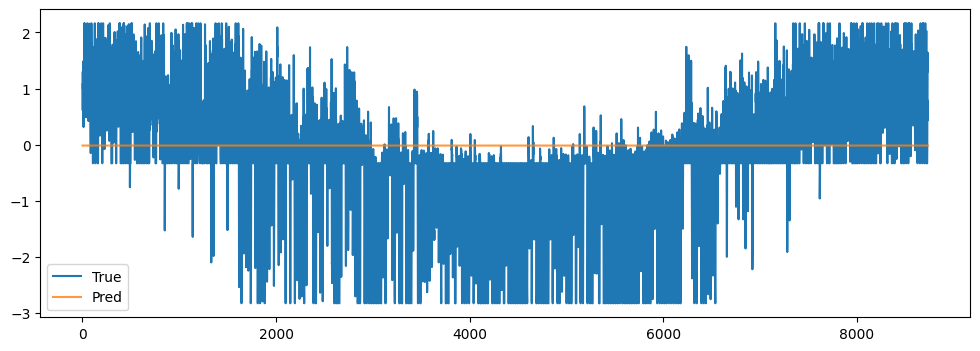

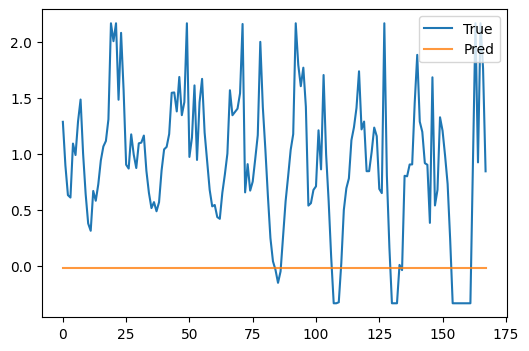

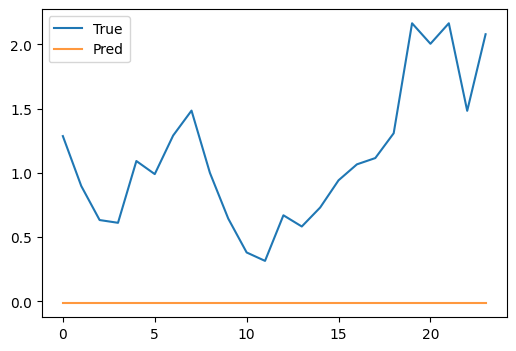

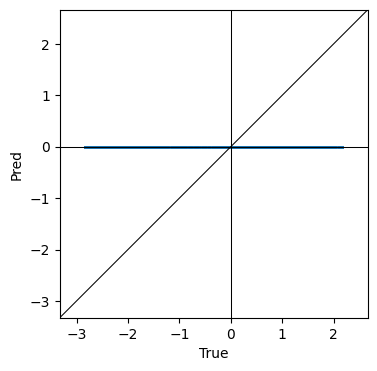

In [7]:
model = sh.loadModel(model_settings["architecture"], model_settings["model_file"])
sh.evaluateModel(model, model_settings["architecture"], model_settings["name"], energydata_test)
prediction = sh.predictData(model, model_settings["architecture"], model_settings["name"], energydata_test, plot = True)

# Transfer

## Load and Augment Transfer Dataset

In [8]:
transferdata = sh.loadData(transfermodel_settings["data_file"])
transferdata = sh.augmentData(transferdata, transferdata_settings["n_scenarios"], transferdata_settings["augment"])
transferdata_train, transferdata_val, transferdata_test, transfer_input_shape = sh.processData(transferdata, transferdata_settings)

Augmenting data with variational mode decomposition with 9 modes
Input shape: (24, 74)
Target shape: (256,)


2024-09-26 13:44:02.782576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Retrain existing Model on Transfer Dataset

In [9]:
if DO_TRANSFER is True:
    transfer_model = sh.loadModel(model_settings["architecture"], model_settings["model_file"])
    transfer_model = sh.transferModel(transfer_model, transfer_input_shape, model_settings["architecture"], transfermodel_settings["name"], transferdata_train, transferdata_val, transfermodel_settings["epochs"], transfermodel_settings["log_folder"], VERBOSITY)
    #transfer_model = sh.finetuneModel(transfer_model, transfer_input_shape, model_settings["architecture"], transfermodel_settings["name"], transferdata_train, transferdata_val, transfermodel_settings["epochs"], transfermodel_settings["log_folder"], VERBOSITY)
    sh.storeModel(transfer_model, model_settings["architecture"], transfermodel_settings["model_file"])

## Evaluate transferred Model

In [10]:
from pathlib import Path
if Path(f"./{model_settings['architecture']}/{transfermodel_settings['model_file']}").is_file():
    transfer_model = sh.loadModel(model_settings["architecture"], transfermodel_settings["model_file"])
    sh.evaluateModel(transfer_model, model_settings["architecture"], transfermodel_settings["name"], transferdata_test)
    transfer_prediction = sh.predictData(
        transfer_model, model_settings["architecture"], transfermodel_settings["name"], transferdata_test, plot = True
    )
else: print("No Transferred Model file found, please transfer a model first.")

No Transferred Model file found, please transfer a model first.
